# detecting stars from scratch

In [1]:
import numpy as np
import pylab as pl
import astroquery.vizier
import astropy.units as u
import pandas as pd
import astropy.wcs as pywcs
import astropy.io.fits as pyfits
import pandas
import scipy.spatial

import mymodule.lib

In [2]:
hdul = pyfits.open('data/mock_star_field.fits') # return a Header Data Unit list (HDU list)
#hdul = pyfits.open('data/m51.fits')
hdu = hdul[0] # return a Header Data Unit (HDU)
im = hdu.data # get the data of the HDU
hdr = hdu.header # get the header of the HDU

## characterize the image

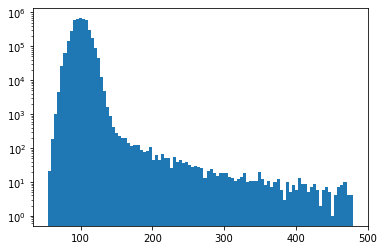

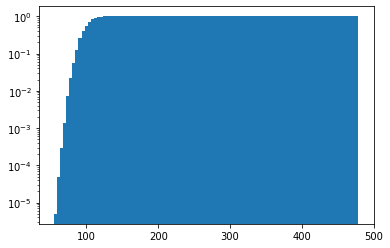

In [3]:
pl.hist(im[im < np.percentile(im, 99.99)], 100)
pl.yscale('log')
pl.figure()
pl.hist(im[im < np.percentile(im, 99.99)], 100, cumulative=True, density=True)
pl.yscale('log')

In [4]:
# background estimation
background = np.median(im)
background_noise = np.std(im[im < 200])
print('background estimation: {} +/- {}'.format(background, background_noise))

background estimation: 100.0 +/- 10.162008030091576


## raw detection
<div>
<img  src="../images/detection.jpg" width="500"/>
</div>

https://66.media.tumblr.com/217667142bd79e1082feb44dcb7b4cf5/tumblr_oc08s1FQlc1tfvz4eo1_640.jpg

In [5]:
# get a list of all the points above a given threshold will give a list of points contained in stars
pixcoords = np.nonzero(im > background + 4 * background_noise)
len(pixcoords[0])

4443

In [6]:
# identify groups of pixels from the same sources and aggregate them

In [7]:
# compute the distance matrix
distance_matrix = scipy.spatial.distance.squareform(
    scipy.spatial.distance.pdist(np.array([pixcoords[0], pixcoords[1]]).T))

In [8]:
MIN_DISTANCE = 5
indices = list(range(len(distance_matrix)))
pixels = list()
while len(indices) > 0:
    new_pixel = list()
    new_pixel.append(indices.pop(0))
    distances = distance_matrix[new_pixel[0]][indices]
    nearest_indices = np.nonzero(distances < MIN_DISTANCE)[0]
    for ii in nearest_indices:
        new_pixel.append(indices.pop(ii))
        nearest_indices -= 1 # each time an item is poped the subsequent indices are reduced by 1
    
    xmean = np.mean(pixcoords[0][new_pixel])
    ymean = np.mean(pixcoords[1][new_pixel])
    pixels.append((xmean, ymean))
len(pixels)

759

## classification

<div>
<img  src="../images/classification.jpg" width="500"/>
</div>
https://retrosci-fi.tumblr.com/post/120397119711/2535223-one-of-my-lamps-retech-oc

Now for each pixel we will check if is a a star or not.

This is called classification : 

The idea is to evaluate the likelihood of an object to fall in a given category. Given a set of **features** $x$, we construct a function $y = f(x)$ which output the index of the category of $x$. A binary classificator (only two categories : `star` or `not star`) will output a 1 or a 0.

The input features in our case are the pixels values taken around the star.

The whole question is `how to build f ?`. For this time we will do it in the most classic way, i.e. with a very simple function, created by hand, without any particular machine learning knowledge.

We will try to extract some charateristics of the image and evaluate the likelihood of this image being a star.

sum of the values above background 1000.0
max of the values above background 75.83246365931296
ratio of sum/max 13.186964417938837


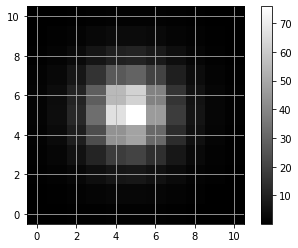

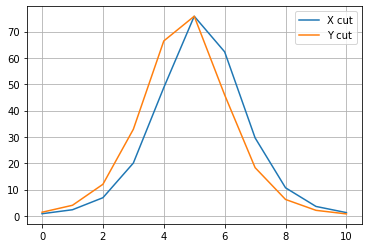

In [9]:
# let's look at a perfect Moffat shape star
star = mymodule.lib.star(11, 1000, 4.7, 5.2)
print('sum of the values above background', np.sum(star))
print('max of the values above background', np.max(star))
print('ratio of sum/max', np.sum(star) / np.max(star))
pl.imshow(star, cmap='gray', origin='bottom-left')
pl.colorbar()
pl.grid()

pl.figure()
pl.plot(np.max(star, axis=1), label='X cut')
pl.plot(np.max(star, axis=0), label='Y cut')
pl.legend()
pl.grid()

sum of the values above background 833.0
max of the values above background 81.0
ratio of sum/max 10.283950617283951


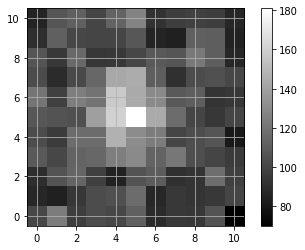

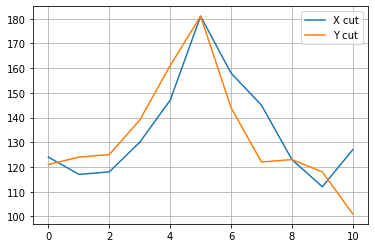

In [10]:
# now we can try to understand how noise will affect the charateristics of the star by simulating it
star = mymodule.lib.star(11, 1000, 4.7, 5.2)
star += background
star = np.random.poisson(star)
print('sum of the values above background', np.sum(star - background))
print('max of the values above background', np.max(star - background))
print('ratio of sum/max', np.sum(star - background) / np.max(star - background))

pl.imshow(star, cmap='gray', origin='bottom-left')
pl.colorbar()
pl.grid()

pl.figure()
pl.plot(np.max(star, axis=1), label='X cut')
pl.plot(np.max(star, axis=0), label='Y cut')
pl.grid()
pl.legend()

In [11]:
def classificator(box, background):
    RATIO = 13.2
    RATIO_RANGE = 8
    star = (box - background)
    ratio = np.sum(star) / np.max(star)
    if RATIO - RATIO_RANGE < ratio < RATIO + RATIO_RANGE:
        return True
    return False

def get_box(im, xy, recenter=True):
    xymin = (np.array(xy) - BOX_SIZE / 2).astype(int)
    xymax = (np.array(xy) + BOX_SIZE / 2 + 1).astype(int)
    # avoid pixels near the border of the image
    if np.any(xymin < 0): return
    if np.any(xymax > min(im.shape)): return    
    box = im[xymin[0]:xymax[0], xymin[1]:xymax[1]] 
    
    # we could return box directly but, 
    # as the star may be decentered in the box,
    # we may want to recenter the box around it
    if not recenter: return box
    xy = np.unravel_index(np.argmax(box), box.shape)
    
    return get_box(im, xy + xymin, recenter=False)
 

BOX_SIZE = 10
good_stars = list()
for istar in pixels:
    ibox = get_box(im, istar)
    if ibox is None: continue
    if classificator(ibox, background): good_stars.append(istar)
good_stars = np.array(good_stars)
len(good_stars)


484

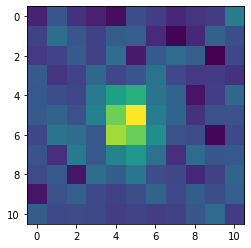

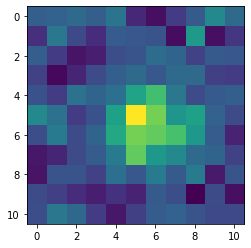

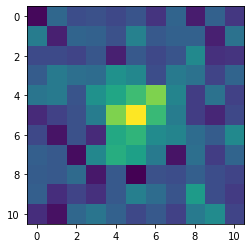

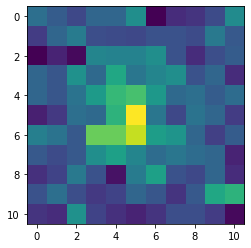

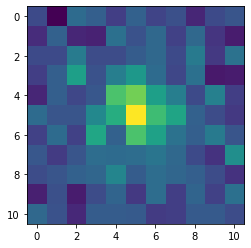

In [12]:
for istar in good_stars[:5]:
    ibox = get_box(im, istar)
    pl.figure()
    pl.imshow(ibox)

## how do we evaluate the performance of a classificator =  ?

<div>
<img  src="../images/women_ray.jpg" width="500"/>
</div>
https://retrosci-fi.tumblr.com/post/151715221418/future-space-girl-with-ray-gun-retro-futurism

we must construct a set of labeled data, i.e. a set of boxes for which we know that a star is present. In this case we can easily simulate the data but we will see later that this is not always so easy.


    

In [13]:
# we are going to look at the preformance wrt star brighness
def simulate_star(brightness, background):
    star = mymodule.lib.star(11, brightness, 4.7, 5.2)
    star += background
    return np.random.poisson(star)

N = 5000
all_brightness = 10**np.linspace(np.log10(30), np.log10(5000), 10)

true_positives = list()
false_positives = list()
true_negatives = list()
false_negatives = list()

for brightness in all_brightness:
    results = list()
    labels = list()
    print('running brightness:', brightness)
    for i in range(N):
        # half samples have no star
        if np.random.uniform() > 0.5:
            b = 0
            labels.append(False)
        else:
            b = float(brightness)
            labels.append(True)
        istar = simulate_star(brightness, background)
        results.append(classificator(istar, background))
    results = np.array(results)
    labels = np.array(labels)
    
    true_positives.append(np.sum(results[labels == 1] == labels[labels == 1]))
    false_positives.append(np.sum(results[labels == 1] != labels[labels == 1]))
    true_negatives.append(np.sum(results[labels == 0] == labels[labels == 0]))
    false_negatives.append(np.sum(results[labels == 0] != labels[labels == 0]))

true_positives = np.array(true_positives)
false_positives = np.array(false_positives)
true_negatives = np.array(true_negatives)
false_negatives = np.array(false_negatives)

len(true_negatives), len(true_positives)

running brightness: 29.999999999999996
running brightness: 52.96553190237298
running brightness: 93.51158565670963
running brightness: 165.09636244473137
running brightness: 291.4805550677383
running brightness: 514.6140879453891
running brightness: 908.5602964160698
running brightness: 1604.079312168491
running brightness: 2832.0304660865595
running brightness: 4999.999999999999


(10, 10)

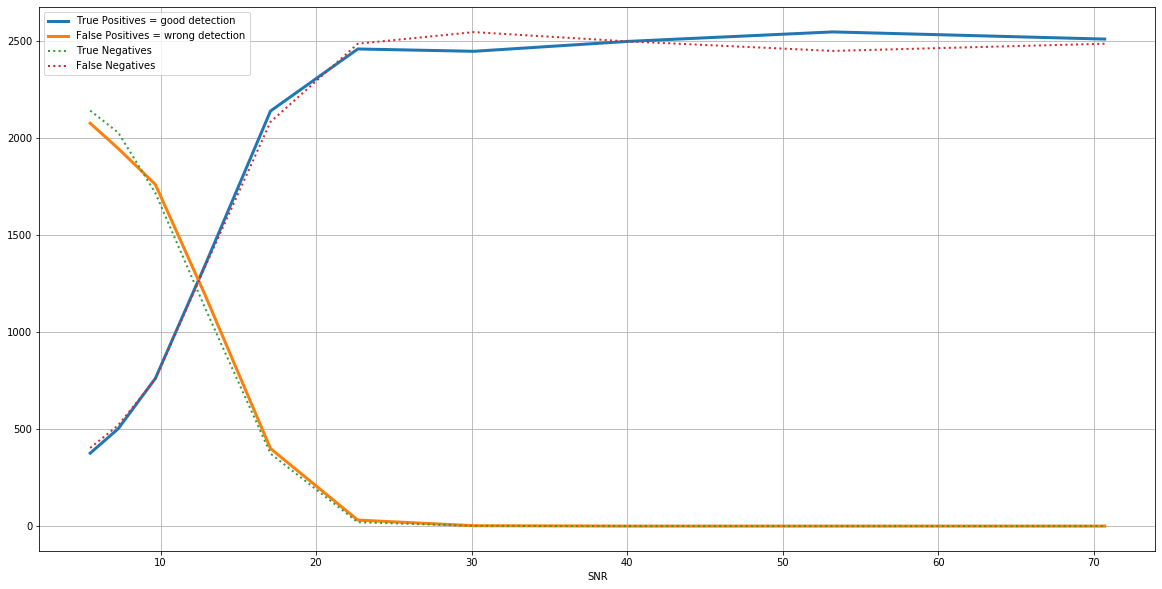

In [14]:
pl.figure(figsize=(20,10))
#x = all_brightness
x = np.sqrt(all_brightness) # snr = brightness / np.sqrt(brightness)
pl.plot(x, true_positives, label='True Positives = good detection', lw=3)
pl.plot(x, false_positives, label='False Positives = wrong detection', lw=3)
pl.plot(x, true_negatives, label='True Negatives', ls=':', lw=2)
pl.plot(x, false_negatives, label='False Negatives', ls=':', lw=2)
pl.xlabel('SNR')
pl.legend()
pl.grid()


## completeness vs reliability
(see e.g. ch 8 of [Wall, J.V & Jenkins, C.R., Practical Statistics for Astronomers](https://doi.org/10.1017/CBO9780511536618))

- completeness =  true positives / positives = true positives / (true positives + false negatives)
- false alarm rate = false positives / detections = false positives / (true positives + false positives)
- reliability = 1 - false alarm rate

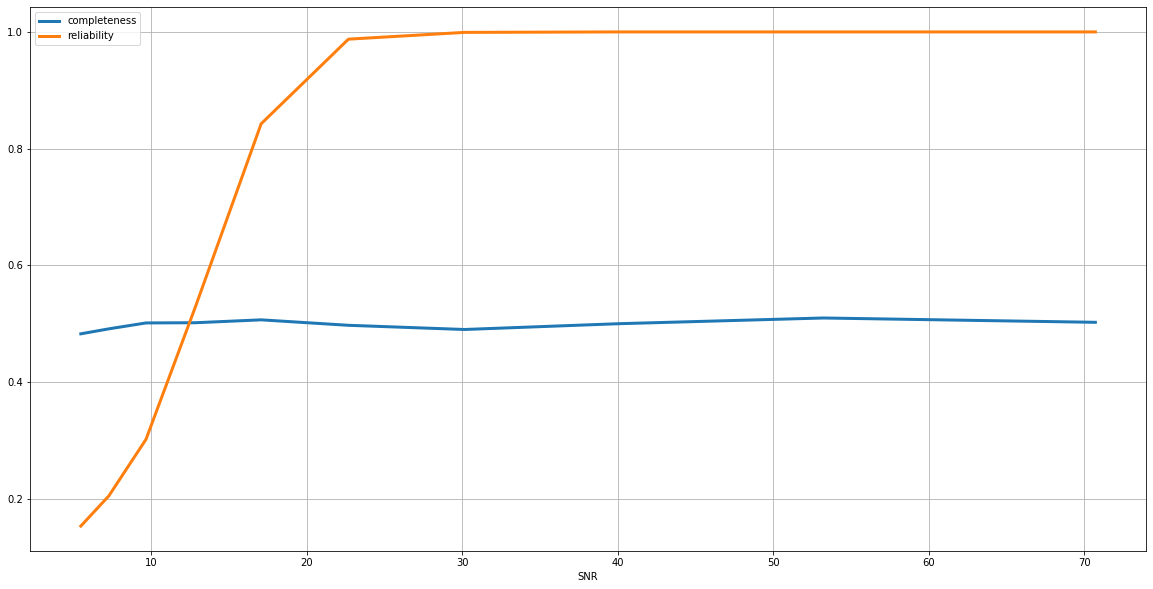

In [18]:
pl.figure(figsize=(20,10))
#x = all_brightness
x = np.sqrt(all_brightness) # snr = brightness / np.sqrt(brightness)
completeness = true_positives / (true_positives + false_negatives)
reliability = 1 - (false_positives / (true_positives + false_positives))
pl.plot(x, completeness, label='completeness', lw=3)
pl.plot(x, reliability, label='reliability', lw=3)
pl.xlabel('SNR')
pl.legend()
pl.grid()